In [6]:
from torchvision import datasets, models, transforms
import torch
from torch import nn
from torch.optim import SGD, Adam
import os
import time
import copy
import numpy as np

In [7]:
sig = nn.Sigmoid()

In [8]:
def FAR_FRR(y_pred, y_true):
    return sum([y_p!=y_t for y_p, y_t in zip(y_pred, y_true)])/y_true.shape[0]

In [41]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    val_far_history = []
    val_frr_history = []


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_uncorrects_false = np.zeros(100)
            running_uncorrects_true = np.zeros(100)
            sum_label_one = 0
            sum_label_two = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = sig(model(inputs)).flatten()
                    loss = criterion(outputs, labels.float())

#                     _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum((outputs >=0.5).int() == labels.data)
                if phase == 'val':
                    for d in range(100):
                        running_uncorrects_false[d] += torch.sum((outputs>=d/100).int() * (labels.data == 0)).cpu().numpy()
                        running_uncorrects_true[d] += torch.sum((outputs<d/100).int() * (labels.data == 1)).cpu().numpy()
                    sum_label_one += torch.sum(labels.data == 1).cpu().numpy()
                    sum_label_two += torch.sum(labels.data == 0).cpu().numpy()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase == 'val':    
                far = running_uncorrects_false / sum_label_two
                frr = running_uncorrects_true / sum_label_one

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_far_history.append(far)
                val_frr_history.append(frr)
                
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_far_history, val_frr_history

In [10]:
 np.zeros(100)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [12]:
num_classes = 1
feature_extract = True
batch_size = 8

In [43]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    model_ft = models.resnet50(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 96

    
    return model_ft, input_size
model_ft, input_size = initialize_model(num_classes, feature_extract)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [44]:
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 fc.weight
	 fc.bias


In [15]:
def targ(x):
    return x if x==1 else 0

In [16]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': datasets.STL10(
        "data",
        split='train',
        transform=data_transforms['train']
#         target_transform=targ
    ),
    'val': datasets.STL10(
        "data",
        split='test',
        transform=data_transforms['val']
#         target_transform=targ
    ),
}

In [17]:
image_datasets['train'].labels = (image_datasets['train'].labels == 1).astype(int)
image_datasets['val'].labels = (image_datasets['val'].labels == 1).astype(int)

In [30]:
from sklearn.utils import class_weight
w = class_weight.compute_class_weight('balanced', np.unique(image_datasets['train'].labels),image_datasets['train'].labels)

C:\Users\Roman\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass classes=[0 1], y=[1 0 1 ... 1 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [31]:
w = np.concatenate(([w[np.newaxis,:]]*batch_size))

In [32]:
w

array([[0.55555556, 5.        ],
       [0.55555556, 5.        ],
       [0.55555556, 5.        ],
       [0.55555556, 5.        ],
       [0.55555556, 5.        ],
       [0.55555556, 5.        ],
       [0.55555556, 5.        ],
       [0.55555556, 5.        ]])

In [45]:
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [46]:

criterion = nn.BCELoss()

model_ft.to(device)
model_ft, hist, far, frr = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1798 Acc: 0.9342
val Loss: 0.1066 Acc: 0.9670

Epoch 1/9
----------
train Loss: 0.1432 Acc: 0.9506
val Loss: 0.0751 Acc: 0.9739

Epoch 2/9
----------
train Loss: 0.1355 Acc: 0.9516
val Loss: 0.0990 Acc: 0.9674

Epoch 3/9
----------
train Loss: 0.1375 Acc: 0.9508
val Loss: 0.0829 Acc: 0.9721

Epoch 4/9
----------
train Loss: 0.1187 Acc: 0.9556
val Loss: 0.0780 Acc: 0.9733

Epoch 5/9
----------
train Loss: 0.1369 Acc: 0.9530
val Loss: 0.0702 Acc: 0.9753

Epoch 6/9
----------
train Loss: 0.1325 Acc: 0.9538
val Loss: 0.0709 Acc: 0.9751

Epoch 7/9
----------
train Loss: 0.1333 Acc: 0.9516
val Loss: 0.0648 Acc: 0.9773

Epoch 8/9
----------
train Loss: 0.1178 Acc: 0.9568
val Loss: 0.0724 Acc: 0.9738

Epoch 9/9
----------
train Loss: 0.1314 Acc: 0.9532
val Loss: 0.0675 Acc: 0.9770

Training complete in 13m 13s
Best val Acc: 0.977250


In [47]:
frr[-1]

array([0.     , 0.00625, 0.01   , 0.01375, 0.015  , 0.01875, 0.02   ,
       0.02375, 0.02625, 0.02625, 0.02625, 0.03   , 0.0325 , 0.0325 ,
       0.03375, 0.035  , 0.0375 , 0.0375 , 0.04   , 0.04   , 0.04   ,
       0.04   , 0.0425 , 0.045  , 0.045  , 0.04625, 0.04625, 0.0475 ,
       0.05125, 0.05375, 0.05375, 0.0575 , 0.05875, 0.05875, 0.06   ,
       0.06125, 0.06125, 0.06375, 0.06625, 0.06625, 0.07125, 0.07625,
       0.08125, 0.0825 , 0.08375, 0.08625, 0.09   , 0.09625, 0.09875,
       0.1    , 0.10125, 0.10125, 0.1025 , 0.1025 , 0.105  , 0.10875,
       0.10875, 0.11   , 0.11125, 0.11375, 0.11875, 0.1225 , 0.12375,
       0.12625, 0.12875, 0.13625, 0.1375 , 0.14   , 0.14375, 0.14625,
       0.1475 , 0.15   , 0.1575 , 0.1575 , 0.16125, 0.1625 , 0.165  ,
       0.17375, 0.17875, 0.18   , 0.18625, 0.1875 , 0.19625, 0.19875,
       0.2025 , 0.205  , 0.21125, 0.215  , 0.225  , 0.23125, 0.24125,
       0.24875, 0.2625 , 0.26875, 0.28375, 0.30125, 0.325  , 0.36375,
       0.42125, 0.51

In [48]:
far[-1]

array([1.00000000e+00, 2.52638889e-01, 1.79305556e-01, 1.43611111e-01,
       1.23611111e-01, 1.11111111e-01, 9.84722222e-02, 9.01388889e-02,
       8.23611111e-02, 7.34722222e-02, 6.81944444e-02, 6.38888889e-02,
       6.00000000e-02, 5.59722222e-02, 5.34722222e-02, 5.08333333e-02,
       4.83333333e-02, 4.54166667e-02, 4.41666667e-02, 4.27777778e-02,
       4.09722222e-02, 4.00000000e-02, 3.86111111e-02, 3.68055556e-02,
       3.56944444e-02, 3.44444444e-02, 3.31944444e-02, 3.13888889e-02,
       2.90277778e-02, 2.79166667e-02, 2.72222222e-02, 2.62500000e-02,
       2.54166667e-02, 2.43055556e-02, 2.37500000e-02, 2.36111111e-02,
       2.26388889e-02, 2.13888889e-02, 2.08333333e-02, 2.04166667e-02,
       1.97222222e-02, 1.93055556e-02, 1.90277778e-02, 1.87500000e-02,
       1.83333333e-02, 1.75000000e-02, 1.69444444e-02, 1.65277778e-02,
       1.58333333e-02, 1.51388889e-02, 1.43055556e-02, 1.36111111e-02,
       1.30555556e-02, 1.29166667e-02, 1.29166667e-02, 1.20833333e-02,
      

In [49]:
import matplotlib.pyplot as plt

In [66]:
EER = far[-1][np.argmin(np.absolute(far[-1] - frr[-1]))]
EER

0.04

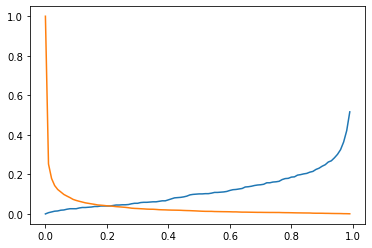

In [67]:
plt.plot(np.array(range(100))/100, frr[-1])
plt.plot(np.array(range(100))/100, far[-1])

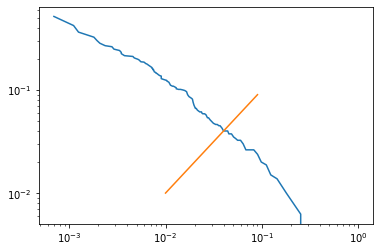

In [70]:
plt.plot(far[-1], frr[-1])
plt.plot(np.arange(0.01, 0.1, 0.01), np.arange(0.01, 0.1, 0.01))
plt.yscale('log')
plt.xscale('log')

In [46]:
outputs = torch.tensor([0, 0.1, 0.2])
labels = torch.tensor([1,1,1])
d = 10
tmp = outputs>=d/100
sum(((outputs>=d/100).int() != labels) * (labels== 0)).numpy()

array(0, dtype=int64)

In [ ]:
dataloaders_dict['train']

In [ ]:
dataloaders_dict['val'].dataset[0]

In [22]:
ch = 0
for i, v in dataloaders_dict['train']:
    ch += 1
    print(f'\r{[ch]}', end='')

[625]

In [13]:
test = datasets.STL10(
        "data",
        split='test'
)

In [19]:
tr = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [30]:
for i in range(400):
    if test[i][1] == 1:
        print(i)
        break

5


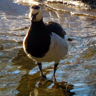

In [31]:
test[5][0]

In [32]:
model_ft(tr(test[5][0]).unsqueeze(0).to(device))

tensor([[-2.0629,  1.3243]], device='cuda:0', grad_fn=<AddmmBackward>)

In [65]:
torch.tensor([1.2,2.1,3.8,4.9]).int()

tensor([1, 2, 3, 4], dtype=torch.int32)